### Data Extraction - Remote Assignment

Expense date (also called spend date) is the exact date on which a financial transaction or operation has happened and must be recognized in the accounting system.

The format of expense dates vary across merchants and the country of issue. In a few cases, the expense date may not be present in the receipt.

### Assignment:

Build a RESTful service that extracts expense date from a receipt. Please feel free to use any language and framework of your choice. Deploy the service on any cloud platform like Heroku/AWS/GCP. The service should contain one API which has the following contract:

Request:
POST /extract_date

Payload:
{“base_64_image_content”: <base_64_image_content>}

Response:
If date is present:
{“date”: “YYYY-MM-DD”}
If date is not present:
{“date”: null}


In [1]:
from scipy.misc.pilutil import imread
from pytesseract import  image_to_string
from PIL import Image,ImageFile
import os
from tqdm import tqdm
from IPython.display import display # to display images
ImageFile.LOAD_TRUNCATED_IMAGES = True
import re
import pickle
import dateutil.parser as dparser
import hashlib
from scipy.misc import imread, imresize, imshow
import matplotlib.pyplot as plt
%matplotlib inline

Dataset can be found here: https://drive.google.com/drive/folders/1tsNzkpVvfbEQDVOFTuverce1CqBUWSYC

I used the following approach in this assignment.
* Data cleaning i.e,removing duplicate files
* pytesseract to do the image to text conversion.
* Using regex and custom made functions to preprocess the text and find the date.

### Find duplicate images using hashlib

In [2]:
#change the directory path to the folder containing  receipt images
os.chdir('./Receipts')
os.getcwd()

'/home/ubuntu/Downloads/Fyle_assignment/Receipts'

In [2]:
def file_hash(filepath):
    with open(filepath, 'rb') as f:
        return md5(f.read()).hexdigest()

In [8]:
duplicates = []
hash_keys = dict()
for index, filename in  enumerate(os.listdir('.')):  #listdir('.') = current directory
    if os.path.isfile(filename):
        with open(filename, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash not in hash_keys: 
            hash_keys[filehash] = index
        else:
            duplicates.append((index,hash_keys[filehash]))

In [9]:
duplicates

[(247, 225), (313, 166), (496, 93), (512, 323), (564, 272), (578, 272)]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


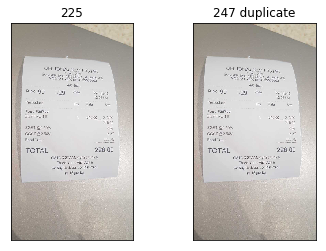

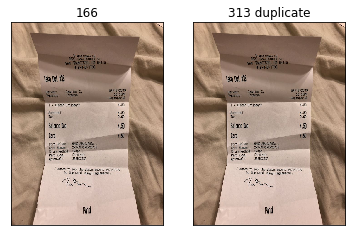

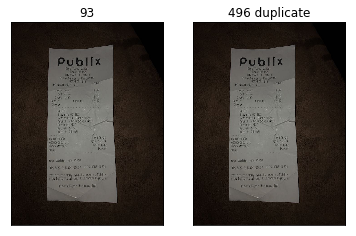

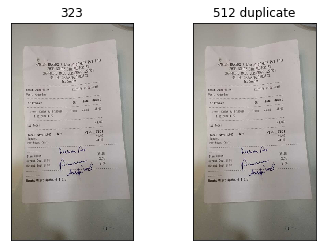

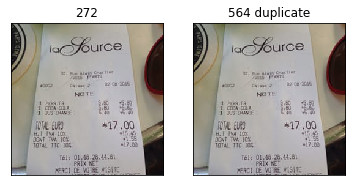

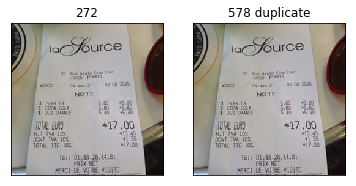

In [11]:
files_list = os.listdir()
for file_indexes in duplicates[:30]:
    try:
    
        plt.subplot(121),plt.imshow(imread(files_list[file_indexes[1]]))
        plt.title(file_indexes[1]), plt.xticks([]), plt.yticks([])

        plt.subplot(122),plt.imshow(imread(files_list[file_indexes[0]]))
        plt.title(str(file_indexes[0]) + ' duplicate'), plt.xticks([]), plt.yticks([])
        plt.show()
    
    except OSError as e:
        continue

### Delete duplicate files 

In [14]:
for index in tqdm(duplicates):
    os.remove(files_list[index[0]])

100%|██████████| 6/6 [00:00<00:00, 7646.86it/s]


### Convert all the images to text

In [3]:
receipts = os.listdir('.') #folder path

In [5]:
all_text = []
for i in tqdm(receipts):
    img = Image.open(i)
    
    txt = image_to_string(img)
    all_text.append(txt.lower())
    
## save all the converted text into a text file using pickle
with open("all_text.txt", "wb") as f:   #Pickling
    pickle.dump(all_text, f)    

100%|██████████| 589/589 [03:30<00:00,  2.37it/s]


In [4]:
#run this directly if you don't want to convert the images into text

with open("all_text.txt", "rb") as f:   # Unpickling
    all_text = pickle.load(f)

In [5]:
print('number of images after deleting duplicates:',len(all_text))

number of images after deleting duplicates: 589


### I have used some basic heuristics after going through the images to get some features. It's not guaranteed to be optimal.


### Majority of the US receipts have the state code and the '$' sign

In [6]:
all_states = ['al','ak','az','ar','ca','co','ct','dc','de','fl','ga','hi','id',
          'il','in','ia','ks','ky','la','me','md','ma','mi','mn','ms','mo',
          'mt','ne','nv','nh','nj','nm','ny','nc','nd','oh','ok','or','pa',
          'ri','sc','sd','tn','tx','ut','vt','va','wa','wv','wi','wy']
#state codes of all US states

In [7]:
print('number of states in the US:',len(all_states))

number of states in the US: 51


In [ ]:
# If date is present:
# {“date”: “YYYY-MM-DD”}
# If date is not present:
# {“date”: null}

In [8]:
def find_if_us(string):
    matches = 0
    allTexts = string.split("\n")
    for entry in allTexts:
        
        storedMatches = []
    
    #for each entry:
        allWords = entry.split(' ')
        for words in allWords:

        #remove punctuation that will interfere with matching
            words = words.replace(',', '')
            words = words.replace('.', '')
            words = words.replace(';', '')


        #if a keyword match is found, store the result.
            if words in all_states:
                if words in storedMatches:
                    continue
                else:
                    storedMatches.append(words)
                
                matches += 1
        
        #if there is a match
        if matches == 0:
            us_state = False
            
        
        
        else:

            us_state = True
            
    return(us_state)


### Finding any characters that might indicate the presence of date in the text

In [9]:
def get_date(string,country):  #country=True ==>US 
    
    if(string==0):
        date = 0
    
    else:
        search = []
        for i in string:
            if(i.isalnum()==True or i=='/' or i =='-'):
                search.append(i)    

        search = "".join(search)
        #return location_based(search,country)
        if country == True:         #country True indicating that it's the US
            try:
                date = dparser.parse(search,fuzzy=True).timetuple()
                date = str(date[0])+"-"+"{0:0=2d}".format(date[1])+"-"+"{0:0=2d}".format(date[2])

            except:
                try:
                    date = dparser.parse(search,fuzzy=True, dayfirst=True)
                    date = str(date[0])+"-"+"{0:0=2d}".format(date[1])+"-"+"{0:0=2d}".format(date[2])
                except:    
                    date = 0
        if country == False:
            try:

                date = dparser.parse(search,fuzzy=True, dayfirst=True)
                date = str(date[0])+"-"+"{0:0=2d}".format(date[1])+"-"+"{0:0=2d}".format(date[2])

            except:
                date = 0
    
    return date

### Using some heuristics here to capture all the date formats that may be found in the text

In [10]:
def heur(string,country):
    

    d1 = re.findall(r"[\d]{1,2}/[\d]{1,2}/[\d]{4}", string)    #12/12/2019
    d2 = re.findall(r"[\d]{1,2}-[\d]{1,2}-[\d]{2}", string)    #12-12-19
    d3 = re.findall(r"(\d{1,2} (?:jan|feb|mar|apr|may|jun|jul|aug|sept|oct|nov|dec) \d{4})", string) #5 mar 2018  
    d4 = re.findall(r"[\d]{1,2}-[\d]{1,2}-[\d]{4}", string)  #02-10-2018
    d5 = re.findall(r"[\d]{4}-[\d]{1,2}-[\d]{1,2}", string)  #2018-10-05
    d6 = re.findall(r"[\d]{1,2}/[\d]{1,2}/[\d]{2}", string)  #05/01/2018
    
    date = max(d1,d2,d3,d4,d5,d6)
    
    
    if date!=[]:
        if(len(date)>1):
            del date[-1]
        date = ''.join(date)
#         return location_based(date,country)
        if(country == True):
            try:
                
                date = dparser.parse(date,fuzzy=True).timetuple()
                date = str(date[0])+"-"+"{0:0=2d}".format(date[1])+"-"+"{0:0=2d}".format(date[2])
            except:
                try:
                    date = dparser.parse(date,fuzzy=True,dayfirst=True).timetuple()
                    date = str(date[0])+"-"+"{0:0=2d}".format(date[1])+"-"+"{0:0=2d}".format(date[2])
                except:
                    date = 0
                    
        if(country == False):
            try:
                
                date = dparser.parse(date,fuzzy=True,dayfirst=True).timetuple()
                date = str(date[0])+"-"+"{0:0=2d}".format(date[1])+"-"+"{0:0=2d}".format(date[2])
            except:
                date = 0
            
    else:
        date = 0
    return date

In [11]:
def to_find(string):
    #searching for comma,slash,dot,hyphen or anything that might indicate the presence of a date
    
        
    try:
            
        ix = [m.start() for m in re.finditer(r'{}'.format(re.escape("/")), string)][-1]
        
        
        
        
    except:
        try:
            
            ix = [m.start() for m in re.finditer(r'{}'.format(re.escape(".")), string)][-1]
            
            
        except:
            try:
                
                ix = [m.start() for m in re.finditer(r'{}'.format(re.escape("'")), string)][-1]
            except:
                try:
                    
                    ix = [m.start() for m in re.finditer(r'{}'.format(re.escape(",")), string)][-1]
                except:
                    try:
                        ix = [m.start() for m in re.finditer(r'{}'.format(re.escape("-")), string)][-1]
                        
                    except:
                        
                        ix = 0
               
                
    return ix        

### find if the keyword date is present in a text and extract the date in that specific format

In [12]:
def found_date(string,country):

    dix = string.find('date')
    q = string[dix:dix+23]
    q = re.sub('[:\n|&?,‘]', ' ', q)
    
    try:
        if(country == False):   
            
            date = dparser.parse(q,fuzzy=True,dayfirst=True).timetuple()
        if(country == True):
            date = dparser.parse(q,fuzzy=True).timetuple()
            
        date = str(date[0])+"-"+"{0:0=2d}".format(date[1])+"-"+"{0:0=2d}".format(date[2])
    except:
        try:

            if(q[to_find(q)+3]!= ' '):
                z = q[0:to_find(q)+6]
                if(country==False):
                    
                    date = dparser.parse(z,fuzzy=True,dayfirst=True).timetuple()
                if(country == True):
                    date = dparser.parse(z,fuzzy=True).timetuple()
                
                date = str(date[0])+"-"+"{0:0=2d}".format(date[1])+"-"+"{0:0=2d}".format(date[2])

            else:
                z = q[0:to_find(q)+3]
                if(country==False):
                    date = dparser.parse(z,fuzzy=True,dayfirst=True).timetuple()
                if(country == True):
                    date = dparser.parse(z,fuzzy=True).timetuple()
                
                date = str(date[0])+"-"+"{0:0=2d}".format(date[1])+"-"+"{0:0=2d}".format(date[2])

        except:
            date = 0
    
        
        
    return date    

* Check is the dictionary we're using to store the dates that we found using some heuristics as mentioned above. 

In [13]:
check = {}
for i in tqdm(range(len(all_text))):        
    
    if((find_if_us(all_text[i])==True) or '$' in all_text[i]):
        check[i] = [True]
        
    else:
        check[i] = [False]
    
    check[i].append(get_date(all_text[i],check[i][0]))
    
    check[i].append(heur(all_text[i],check[i][0]))

    check[i].append(found_date(all_text[i],check[i][0]))    
        

100%|██████████| 589/589 [00:00<00:00, 1962.17it/s]


In [14]:
#first 10 elements of check
list(check.items())[0:10]

[(0, [True, 0, 0, '2027-06-07']),
 (1, [False, 0, '2019-06-17', 0]),
 (2, [False, 0, 0, 0]),
 (3, [False, 0, 0, 0]),
 (4, [True, '2018-11-01', '2018-11-01', 0]),
 (5, [False, 0, 0, 0]),
 (6, [True, 0, 0, '2018-09-07']),
 (7, [True, 0, '2019-06-20', 0]),
 (8, [False, 0, 0, 0]),
 (9, [False, 0, 0, 0])]

* The boolean values in the dictionary check denotes the following:
* True ==> Receipt is from US 
* False ==> Not from US
* This was found using some heuristics in the converted text.

#### Removed those elements in check which had no date and saved only those elements with date in a new list 'found_some_date'

In [15]:
#found some date (regadless of whether they're right or not)
found_some_date = [j for i,j in enumerate(check.items())if( check[i][1] !=0 or check[i][2] !=0  or check[i][3] != 0 )]
perc = len(found_some_date)/589*100
print('found some dates from receipts:',len(found_some_date),'out of',len(all_text),'\n(correct and incorrect dates)','\n\nin percentage',perc,'%')
#percentage of predicted dates


found some dates from receipts: 273 out of 589 
(correct and incorrect dates) 

in percentage 46.349745331069606 %


In [426]:
response_date = {}
for i in range(len(check.values())):
    if(len([num for num in check[i] if (num and type(num)!=bool)])!=0):
        response_date[i] = {"date: " +str([num for num in check[i] if (num and type(num)!=bool)][0])}
    else:
        response_date[i] = {None}
       

In [442]:
response_date

{0: {'date: 2027-06-07'},
 1: {'date: 2019-06-17'},
 2: {None},
 3: {None},
 4: {'date: 2018-11-01'},
 5: {None},
 6: {'date: 2018-09-07'},
 7: {'date: 2019-06-20'},
 8: {None},
 9: {None},
 10: {None},
 11: {'date: 2015-03-14'},
 12: {'date: 2019-11-06'},
 13: {'date: 2019-06-26'},
 14: {'date: 2018-12-02'},
 15: {None},
 16: {None},
 17: {None},
 18: {None},
 19: {'date: 2049-05-23'},
 20: {'date: 2019-07-08'},
 21: {'date: 2019-06-10'},
 22: {None},
 23: {'date: 2019-05-20'},
 24: {'date: 2019-01-03'},
 25: {None},
 26: {'date: 1330-08-22'},
 27: {None},
 28: {None},
 29: {'date: 2019-06-27'},
 30: {None},
 31: {None},
 32: {'date: 2015-08-30'},
 33: {'date: 2019-11-07'},
 34: {None},
 35: {'date: 2019-06-29'},
 36: {'date: 2019-07-03'},
 37: {None},
 38: {'date: 2009-06-23'},
 39: {'date: 2019-04-28'},
 40: {'date: 2018-07-01'},
 41: {'date: 2016-09-24'},
 42: {None},
 43: {'date: 2017-12-17'},
 44: {None},
 45: {'date: 2019-06-22'},
 46: {None},
 47: {'date: 2019-11-15'},
 48: {'d

In [75]:
# If date is present:
# {“date”: “YYYY-MM-DD”}
# If date is not present:
# {“date”: null}

* In the real world, the images would be unlabelled for this problem. 
* So the accuracy can only be found found  by manually looking at each and every receipt.

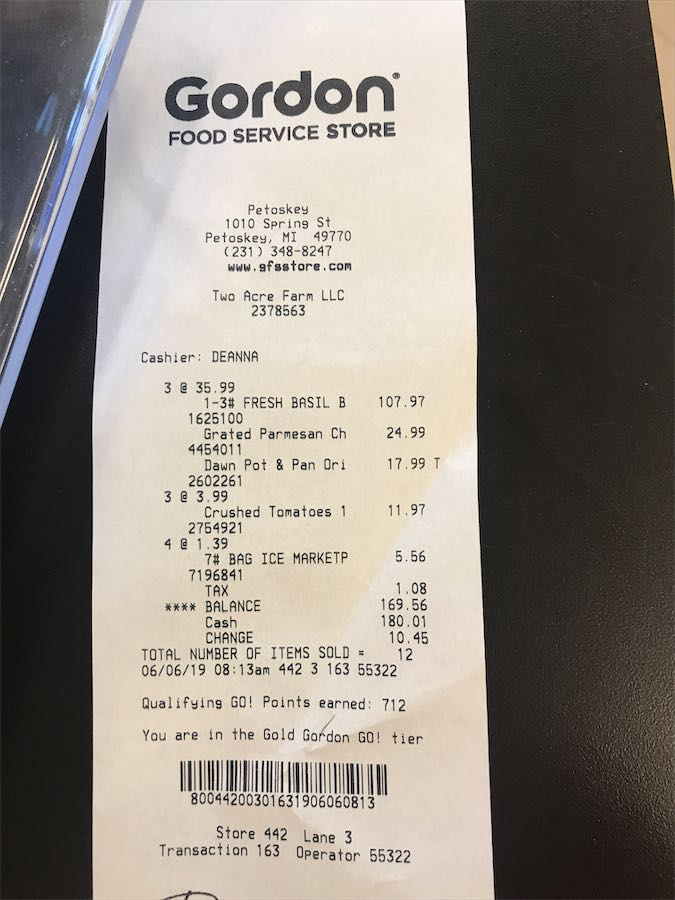

In [383]:
receipts = os.listdir('.')   #folder path containing images of receipts
pil_im = Image.open(receipts[585])
display(pil_im)

### Accuracy
Calculate the accuracy of the service against the sample receipts dataset given. This can be calculated as follows:

accuracy = (number of receipts for which the service extracted correct date/total receipts)*100%



### Observation and Result
* After going through each and every image, 33% of the dates were found to be correct. (190 out of 589 images).
So my accuracy is 33%
* The dataset given for this problem was unlabelled.
* It was tedious to look through each and every image manually to find out if the dates were correct.
* The challenging part was to get the location of the receipt.
* Pytesseract,hashlib and dateutil.parser,PIL,regex and other libraries have been used in this assignment.
* Although pytesseract is one of the state of the art image to text conversion libraries that are out there, I think using a custom ocr model for this problem would do better because we are only interested to find the date in a receipt and not any other form of text. 
